# Recreating the original visualization which can be found [here](https://nhltoseattle.com/2013/02/10/nhl-attendance-through-feb-9th/).

In [1]:
#variables
max_season = '2017-18'
min_season = '2000-01'

In [2]:
import math
import numpy as np 
import pandas as pd
from PIL import Image

import matplotlib as matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{xcolor}')
rc('pgf', preamble=r'\usepackage{xcolor}', rcfonts=False)

import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns

pd.options.mode.chained_assignment = None # surpress is copy warning

In [3]:
df = pd.read_csv('../NHL Attendance.csv')
print(df.columns)
print(df.head())

Index(['SEASON', 'RANK', 'TEAM', 'HOME GAMES', ' HOME ATTENDANCE ',
       'ROAD GAMES', ' ROAD ATTENDANCE ', 'TOTAL GAMES', ' TOTAL ATTENDANCE '],
      dtype='object')
    SEASON  RANK          TEAM  HOME GAMES  HOME ATTENDANCE   ROAD GAMES  \
0  2017-18     1       Chicago          41          887,794           41   
1  2017-18     2      Montreal          41          873,283           41   
2  2017-18     3  Philadelphia          41          800,214           41   
3  2017-18     4       Detroit          41          800,115           41   
4  2017-18     5       Toronto          41          786,677           41   

   ROAD ATTENDANCE   TOTAL GAMES  TOTAL ATTENDANCE   
0          723,773            82         1,611,567   
1          733,736            82         1,607,019   
2          702,781            82         1,502,995   
3          717,295            82         1,517,410   
4          751,940            82         1,538,617   


In [4]:
def clean_numeric_column(df, column_name):
    series = df[column_name].str.strip()
    series = series.str.replace(',', '')
    series = pd.to_numeric(series)
    df[column_name] = series
    return df

df = df.query('TEAM != "Vegas"')
df = clean_numeric_column(df, ' TOTAL ATTENDANCE ')
df = clean_numeric_column(df, ' HOME ATTENDANCE ')

In [5]:
prepared_df = df.groupby(['TEAM', 'SEASON']).sum()
prepared_df = prepared_df.reset_index(level=['TEAM', 'SEASON'])
prepared_df['AVERAGE HOME ATTENDANCE'] = prepared_df[' HOME ATTENDANCE '] / prepared_df['HOME GAMES']
prepared_df = prepared_df.sort_values(by='TEAM')

print(prepared_df[['TEAM', 'SEASON', 'AVERAGE HOME ATTENDANCE']].query('SEASON == @max_season').head())

       TEAM   SEASON  AVERAGE HOME ATTENDANCE
16  Anaheim  2017-18             16635.609756
33  Arizona  2017-18             13040.731707
50   Boston  2017-18             17565.000000
67  Buffalo  2017-18             18563.512195
84  Calgary  2017-18             18905.000000


In [6]:
max_season_data = prepared_df.query('SEASON == @max_season')
min_season_data = prepared_df.query('SEASON == @min_season')

max_season_data['MIN SEASON HOME ATTENDANCE'] = min_season_data[' HOME ATTENDANCE '].tolist()
max_season_data['INCREASE SINCE MIN YEAR'] = (max_season_data[' HOME ATTENDANCE '] / max_season_data['MIN SEASON HOME ATTENDANCE']) - 1

In [7]:
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.title('NHL Home Attendance', loc='center', pad=20, size=40)

# Drawing - Bar graph
ax = sns.barplot(x="TEAM", y="AVERAGE HOME ATTENDANCE", data=max_season_data, zorder=3)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Average Home attendance in ' + max_season, size=15, labelpad=20)

plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right', size=15)
plt.xlabel('')


# Drawing - Line graph
ax2 = ax.twinx()
sns.lineplot(ax=ax2, x="TEAM", y='INCREASE SINCE MIN YEAR', data=max_season_data, zorder=5)
ax2.set_ylabel('Percent Increase since ' + min_season, size=15, labelpad=20)
ax2_y_ticks = np.arange(-.20, .50, .10)
ax2.set_yticks(ax2_y_ticks)
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2_y_ticks])


# Marking graph
ax2.axhline(y=0, linewidth=1, color='lightgray')


# Save figure
file_name = 'Week1_NHL_Original.pdf'
plt.savefig(file_name)
matplotlib.pyplot.close(fig) #do not draw

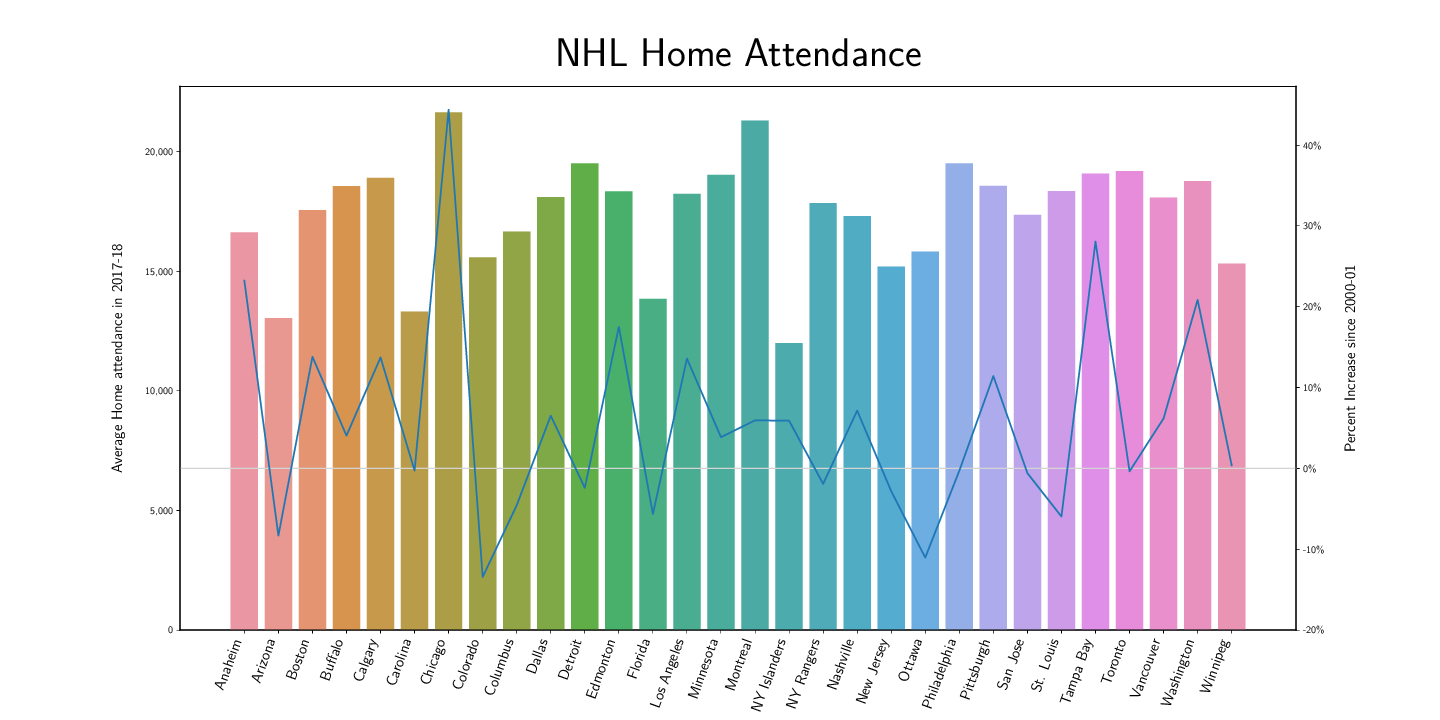

In [8]:
from wand.image import Image  

imageFromPdf = Image(filename=file_name)  
pages = len(imageFromPdf.sequence)  

image = Image(  
  width=imageFromPdf.width,  
  height=imageFromPdf.height * pages  
)  
for i in range(pages):  
  image.composite(  
  imageFromPdf.sequence[i],  
  top=imageFromPdf.height * i,  
  left=0  
)  
image.format="png"  
image